# Exploring Player Data on Stratus: A Web Scraping and EDA Project
---
- **Made by:** *Philip Sinnott*
- **GitHub:** [@philipsinnott](https://github.com/philipsinnott)
- **Blog:** [sinnott.netlify.app](https://sinnott.netlify.app)

# 1. Background
---
In this project, I aim to explore player data on the Minecraft PvP server [Stratus](https://stratus.network) (stratus.network) through web scraping and exploratory data analysis (EDA). By gathering data from the leaderboards and individual player pages on the website, I aim to provide insights into the performance and statistics of the top players on the server.

# 2. Scope and Delimitations
---
One limitation of the data scraped from the leaderboards page is that it's missing important variables such as games played and total number of losses, which are crucial for calculating win-loss ratios and other important metrics for the eventual EDA. In order to gather the missing data, I created a list of the top 100 players using the leaderboards dataset, and then scraped each of these players' individual player pages on the website. By doing this, I was able to complement the leaderboards dataset with not only the missing metrics, but also with other interesting metrics such as best winstreak, amount of double losses, and much more.
<br>
<br>
I will primarily focus on statistics from season 14 and 15.

# 3. Web scraping
---
I used [requests](https://pypi.org/project/requests) to retrieve the data from the website, [BeautifulSoup4](https://pypi.org/project/beautifulsoup4) to easily navigate through the HTML structure of the content and manipulate the data as needed, and [pandas](https://pandas.pydata.org) to store the data in a dataframe for further data manipulation.
<br>
<br>
It's also worth mentioning that transforming the data from the leaderboards dataset into plottable data required significantly more effort in comparison to the player profile dataset.

## 3.1 Acquire data
---

In [65]:
# Imports
from bs4 import BeautifulSoup
import requests
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy import stats
import json
import re
from itertools import chain
from concurrent.futures import ThreadPoolExecutor
import threading
import itertools
import urllib.request
from PIL import Image

In [66]:
def get_data_as_soup(url):
    data = requests.get(url).text
    soup = BeautifulSoup(data, "html.parser")
    return soup

In [67]:
url = "https://stratus.network/leaderboard/stratus14,*,*,*/wins/1"
soup = get_data_as_soup(url)
#soup

<!DOCTYPE html>
<html><head><style>@import url('https://fonts.googleapis.com/css2?family=Heebo:wght@400;700;900&display=swap');@font-face{font-family:"Heebo";src:local("Helvetica Neue"),local("Arial");unicode-range:U+60;font-weight:400;font-style:normal;}@font-face{font-family:"Heebo";src:local("Helvetica Neue"),local("Arial");unicode-range:U+60;font-weight:700;font-style:normal;}@font-face{font-family:"Heebo";src:local("Helvetica Neue"),local("Arial");unicode-range:U+60;font-weight:900;font-style:normal;}strong,b{font-weight:700!important}</style><meta charset="utf-8"/><title>Leaderboard — Stratus Network</title><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="JhKY6VEV-7JXjMKODTcXN0f3RWOF_eYxaVTU" name="csrf-token"/><style id="prerender-css">.MuiSvgIcon-root {
  fill: currentColor;
  width: 1em;
  height: 1em;
  display: inline-block;
  font-size: 1.5rem;
  transition: fill 200ms cubic-bezier(0.4, 0, 0.2, 1) 0ms;
  flex-shrink: 0;
  user-select: none

In [68]:
def scrape_lb_data(soup):
    # Get name of each column header
    t_head = soup.find_all("tr", "MuiTableRow-root MuiTableRow-head")

    # Append each column header to a list
    column_headers = []
    for i in t_head:
        for j in i.find_all("th"):
            column_headers.append(j.text)
    
    # Get data from top table body containing top 100 players
    t_body = soup.find_all("tr", class_="MuiTableRow-root")
    rank_rows = soup.find_all("tr", class_="MuiTableRow-root")
    players_data = []
    current_player = []
    # Loop through each row on leaderboard
    for i, rank_row in zip(t_body, rank_rows):
        rank = rank_row.find("td", class_="MuiTableCell-root MuiTableCell-body jss41 MuiTableCell-alignRight")
        if rank:
            current_player.append(rank.text)
        for j in i.find_all("span"):
            data = j.text.strip()
            #print(data)
            current_player.append(data)
        # If list containing player data isn't empty --> append to list containing all player data
        if current_player:
            players_data.append(current_player)
        # Reset list for next player
        current_player = []
    # Append last player on leaderboard to list containing all player data
    if current_player:
        players_data.append(current_player)
    # Return 2D list where each player corresponds to one sublist, along with the column headers
    return [players_data, column_headers]

In [69]:
players_data = scrape_lb_data(soup)[0] # body data
column_headers = scrape_lb_data(soup)[1] # header
#players_data

[['#1',
  'ak4shiro',
  '825',
  '18,181',
  '17,343',
  '1.05',
  '331k',
  '12.08/game',
  '24\u2006/min',
  '2.07',
  '41%',
  '142',
  '27,352',
  '5,428.9'],
 ['#2',
  'Heldd',
  '777',
  '16,009',
  '17,704',
  '0.90',
  '282k',
  '11.08/game',
  '21.5\u2006/min',
  '2.65',
  '40%',
  '159',
  '25,148',
  '-1,552.4'],
 ['#3',
  'thxchase',
  '698',
  '14,589',
  '15,476',
  '0.94',
  '268k',
  '11.17/game',
  '23.5\u2006/min',
  '2.35',
  '45%',
  '89',
  '22,411',
  '239.2'],
 ['#4',
  'zamph',
  '603',
  '14,918',
  '12,390',
  '1.20',
  '243k',
  '13.60/game',
  '24\u2006/min',
  '2.59',
  '44%',
  '86',
  '19,224',
  '5,562.4'],
 ['#5',
  'lilkvneki77',
  '575',
  '11,068',
  '14,394',
  '0.77',
  '208k',
  '10.31/game',
  '21.5\u2006/min',
  '2.89',
  '38%',
  '111',
  '19,605',
  '-4,334.4'],
 ['#6',
  'nekfroid',
  '553',
  '14,459',
  '12,144',
  '1.19',
  '227k',
  '12.78/game',
  '23\u2006/min',
  '2.76',
  '38%',
  '52',
  '20,702',
  '4,444.5'],
 ['#7',
  'ezrs',
  '5

## 3.2 Data Conversion & Preprocessing
---

In [70]:
def clean_lb_data(data, cols):   
    # Creating the df
    df = pd.DataFrame(data, columns=cols)
    # Rename ranking col
    df.rename(columns={"#":"Ranking"}, inplace=True)
    
    # Remove unwanted chars from data so we eventually can store all vars in numeric form
    df["Kills per Game"] = df["Kills per Game"].str.removesuffix("/game")
    df["Damage Dealt per Minute"] = df["Damage Dealt per Minute"].str.removesuffix("\u2006/min")
    df["Ranking"] = df["Ranking"].str.replace("#", "")
    df["Bow Accuracy"] = df["Bow Accuracy"].str.replace("%", "")

    # Remove commas
    for col in df.columns:
        df[col] = df[col].str.replace(",", "")

    # Transform all cols except for Player from obj --> numerical dtype
    for col in df.columns[[0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Store bow accuracy metric in float instead of percentage
    df["Bow Accuracy"] = df["Bow Accuracy"].apply(lambda x: x / 100)

    # Show values in full length, e.g. "1.5M" --> "1500000" and "500k" --> "500000"
    # also converts values to ints
    df["Damage Dealt"] = df["Damage Dealt"].apply(lambda x: pd.to_numeric(x.replace('M',''))*1000000 if 'M' in x
                                                      else pd.to_numeric(x.replace('k',''))*1000 if 'k' in x
                                                          else pd.to_numeric(x))
    df["Damage Dealt"] = df["Damage Dealt"].astype(int)
    
    return df

In [71]:
df_lb = clean_lb_data(players_data, column_headers)

# Print info and make sure all columns except for "Player" are numeric dt
#print(df_lb.info())
#df_lb

,Ranking,Player,Wins,Kills,Deaths,KDR,Damage Dealt,Kills per Game,Damage Dealt per Minute,Melee/Bow Damage Ratio,Bow Accuracy,Flags,Golden Apples Eaten,Rating
0,1,ak4shiro,825,18181,17343,1.05,331000,12.08,24.0,2.07,0.41,142,27352,5428.9
1,2,Heldd,777,16009,17704,0.90,282000,11.08,21.5,2.65,0.40,159,25148,-1552.4
2,3,thxchase,698,14589,15476,0.94,268000,11.17,23.5,2.35,0.45,89,22411,239.2
3,4,zamph,603,14918,12390,1.20,243000,13.60,24.0,2.59,0.44,86,19224,5562.4
4,5,lilkvneki77,575,11068,14394,0.77,208000,10.31,21.5,2.89,0.38,111,19605,-4334.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Dukih,158,3605,3931,0.92,60800,10.96,21.0,4.09,0.35,39,5887,-517.9
96,97,Abelpvp2007,156,3263,3526,0.93,59200,10.26,21.0,2.27,0.43,36,5278,-188.5
97,98,DivineXevion,155,4027,3843,1.05,68600,13.20,24.0,2.36,0.41,10,6532,202.8
98,99,Skyxzzz,155,3643,3768,0.97,59300,12.43,23.0,4.23,0.41,20,6236,-78.8


## 3.3 Complementing the Leaderboards Dataset with Player Profile Data
---

In [72]:
base_url = "https://stratus.network/"

def scrape_player_profile_data(season, df):
    players = df["Player"].to_list() # get all player names from lb list
    # i keep getting errors when player "sqyid" is in list, so i removed him
    if any(x == "sqyid" for x in players):
        players.remove("sqyid")
    
    threads = []
    players_data = []
    # iterates over all players
    for player in players:
        # creates a new thread for each player
        thread = threading.Thread(target=process_player, args=(player, season, players_data))
        thread.start()
        threads.append(thread)
    # wait until all threads have finished processing
    for thread in threads:
        thread.join()
        
    return players_data

def process_player(player, season, players_data):
    url = f"{base_url}{player}" # craft url for player
    data = requests.get(url).text # get html in raw text format
    data = BeautifulSoup(data, "html.parser") # create soup object
    
    # filter data to where relevant stats start
    data = data.find('script', text=lambda t: t.startswith('window.initialReactProps='))
    # remove script tags
    data = json.loads(data.text.split("=")[1][:-1])
    # convert string to dictionary
    data = json.loads(data)
    # specify what json object we're looking for
    data = data["props"]["ranked"]
    # use dict comprehension to add key-value pair containing name/ign of player
    data = [{'Name': player, **d} for d in data]
    # search for specific season and show stats from that season
    player_data = list(filter(lambda x: x["season"] == (f"{season}"), data))
    # append individual player data to main list
    players_data.append(player_data)

In [73]:
df_profile = scrape_player_profile_data(15, df_lb)
#df_profile

[[{'Name': 'Levier',
   'best_elo': 260,
   'games': 40,
   'wins': 17,
   'winstreak': 0,
   'best_winstreak': 7,
   'losses': 21,
   'kills': 0,
   'deaths': 0,
   'premium_games': 0,
   'premium_wins': 0,
   'premium_losses': 0,
   'premium_kills': 0,
   'premium_deaths': 0,
   'double_losses': 0,
   'elo': 175,
   'discord': '555189998735982613',
   'season': '15',
   'baseSeason': '15',
   'discordName': 'Stratus',
   'name': 'Stratus Season 15',
   'wellFormed': True,
   'rank': {'min': 100,
    'name': 'Bronze+',
    'image': '/static/img/icons/ranked/bronze.svg',
    'color': '#8D4533'}}],
 [{'Name': 'OnekillXD',
   'best_elo': 230,
   'games': 59,
   'wins': 25,
   'winstreak': 0,
   'best_winstreak': 4,
   'losses': 32,
   'kills': 0,
   'deaths': 0,
   'premium_games': 0,
   'premium_wins': 0,
   'premium_losses': 0,
   'premium_kills': 0,
   'premium_deaths': 0,
   'double_losses': 0,
   'elo': 150,
   'discord': '555189998735982613',
   'season': '15',
   'baseSeason': '15

### 3.3.1 Data Conversion & Preprocessing

In [74]:
# Flatten list of lists and convert to df
def process_player_profile_data(data):
    # flatten 2D list --> 1D list
    flat_data = list(chain.from_iterable(data))
    # convert to df
    df_player_profile = pd.DataFrame.from_records(flat_data)
    # rename name/ign col to suit lb dataset
    df_player_profile.rename(columns={"Name":"Player"}, inplace=True)
    return df_player_profile

In [75]:
df_profile = process_player_profile_data(df_profile)
#df_profile.describe() # show metrics
#df_profile

,Player,best_elo,games,wins,winstreak,best_winstreak,losses,kills,deaths,premium_games,...,premium_deaths,double_losses,elo,discord,season,baseSeason,discordName,name,wellFormed,rank
0,Levier,260,40,17,0,7,21,0,0,0,...,0,0,175,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 100, 'name': 'Bronze+', 'image': '/sta..."
1,OnekillXD,230,59,25,0,4,32,0,0,0,...,0,0,150,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 100, 'name': 'Bronze+', 'image': '/sta..."
2,Amiinos,680,93,53,0,9,36,0,0,0,...,0,0,580,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 500, 'name': 'Gold+', 'image': '/stati..."
3,thxchase,490,107,56,2,6,45,0,0,0,...,0,3,490,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 400, 'name': 'Gold', 'image': '/static..."
4,cityxl_,345,50,28,0,4,21,0,0,7,...,94,0,310,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 300, 'name': 'Silver+', 'image': '/sta..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,iWrekt,355,87,34,0,4,44,0,0,0,...,0,0,185,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 100, 'name': 'Bronze+', 'image': '/sta..."
85,DivineXevion,425,78,39,1,6,36,0,0,43,...,560,0,425,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 400, 'name': 'Gold', 'image': '/static..."
86,Blaszczak,245,34,14,0,6,17,0,0,26,...,314,0,195,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 100, 'name': 'Bronze+', 'image': '/sta..."
87,inowze,255,45,20,0,4,25,0,0,33,...,431,1,215,555189998735982613,15,15,Stratus,Stratus Season 15,True,"{'min': 200, 'name': 'Silver', 'image': '/stat..."


### 3.3.2 Merge Datasets

In [76]:
# Merge extended df with already existing df
# and do some basic processing
def merge_lb_and_player_profile_data(df1, df2):
    # merge dfs
    df_merged = pd.merge(df1, df2, on='Player')
    # add w/l column
    df_merged = df_merged.assign(w_l=df_merged['Wins'] / df_merged['losses'])
    # convert season column from obj to int
    df_merged['season'] = df_merged['season'].astype(int)
    return df_merged

# drop irrelevant cols
def drop_cols(df, cols, axis):
    df = df.drop(columns=cols, axis=axis)
    return df

In [77]:
df_merged = merge_lb_and_player_profile_data(df_lb, df_profile)
df = drop_cols(df_merged, cols=["discord", "season", "baseSeason", "discordName", "name", "wellFormed", "rank", "kills", "deaths"], axis=1)
#df

In [79]:
# Create non_prem df for all columns except for those related to premium queue
def create_non_prem_df(df, cols, axis):
    df_non_prem = df.drop(columns=cols, axis=axis)
    return df_non_prem

In [ ]:
df_non_prem = df.drop(columns=["premium_games", "premium_wins", "premium_losses", "premium_kills", "premium_deaths"], axis=1)
#df_non_prem

In [83]:
def create_df(season):
    # set base url for lb data
    base_url_lb = "https://stratus.network/leaderboard/"
    # get lb data
    lb_data = get_data_as_soup(f"{base_url_lb}stratus{season},*,*,*/wins/1")
    players_data = scrape_lb_data(lb_data)[0]
    column_headers = scrape_lb_data(lb_data)[1]
    lb_data = clean_lb_data(players_data, column_headers)
    
    # get player profile data
    player_profile_data = scrape_player_profile_data(season, lb_data)
    # process player profile data
    player_profile_data = process_player_profile_data(player_profile_data)
    # merge lb data and player profile data
    df_merged = merge_lb_player_datasets(lb_data, player_profile_data)
    # drop unneeded columns
    df = drop_cols(df_merged, cols=["discord", "baseSeason", "discordName", "name", "wellFormed", "rank", "kills", "deaths"], axis=1)
    # create separate df with premium queue columns excluded
    df_non_prem = create_non_prem_df(df, cols=["premium_games", "premium_wins", "premium_losses", "premium_kills", "premium_deaths"], axis=1)
    return [df, df_non_prem]

In [84]:
# Create multiple dfs for specified seasons
def create_multiple_dfs(seasons):
    dfs = []
    dfs_non_prem = []
    for season in seasons:
        df_season, df_non_prem_season = create_df(season)
        dfs.append(df_season)
        dfs.append(df_non_prem_season)
        dfs_non_prem.append(df_non_prem_season)
    return [dfs, dfs_non_prem]

[dfs, dfs_non_prem] = create_multiple_dfs([13, 14, 15])

In [85]:
# Split seasons into separate dfs
s13 = dfs[0]
s13_non_prem = dfs[1]

s14 = dfs[2]
s14_non_prem = dfs[3]

s15 = dfs[4]
s15_non_prem = dfs[5]

# 4. Exploratory Data Analysis (EDA)
---
I used mostly [Matplotlib](https://pypi.org/project/matplotlib/) and [Seaborn](https://pypi.org/project/seaborn/) for plotting the data.

## 4.1 Overview of The Data
---
The data used for the EDA is split into three seasons: **season 13**, **14**, and the ongoing **season 15**. Each season represents a different period of time in which the players competed on the server. The dataset for season 13 and 14 include the final top 100 players on the leaderboard, while the dataset for season 15 includes the (current) top 100 players on the leaderboard. The metric used for determining placement on the leaderboard is amount of wins, which means that players who have more game time will naturally tend to be higher up on the leaderboard.

### 4.1.1 Season 13

In [17]:
print(f"Season 13: {s13.info()}\n{s13.describe()})")
print(f"[Null values]:\n{s13.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  100 non-null    int64  
 1   Player                   100 non-null    object 
 2   Wins                     100 non-null    int64  
 3   Kills                    100 non-null    int64  
 4   Deaths                   100 non-null    int64  
 5   KDR                      100 non-null    float64
 6   Damage Dealt             100 non-null    int32  
 7   Kills per Game           100 non-null    float64
 8   Damage Dealt per Minute  100 non-null    float64
 9   Melee/Bow Damage Ratio   100 non-null    float64
 10  Bow Accuracy             100 non-null    float64
 11  Flags                    100 non-null    int64  
 12  Golden Apples Eaten      100 non-null    int64  
 13  Rating                   100 non-null    float64
 14  best_elo                 10

### 4.1.2 Season 14

In [18]:
print(f"Season 14: {s14.info()}\n{s14.describe()}")
print(f"[Null values]:\n{s14.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  100 non-null    int64  
 1   Player                   100 non-null    object 
 2   Wins                     100 non-null    int64  
 3   Kills                    100 non-null    int64  
 4   Deaths                   100 non-null    int64  
 5   KDR                      100 non-null    float64
 6   Damage Dealt             100 non-null    int32  
 7   Kills per Game           100 non-null    float64
 8   Damage Dealt per Minute  100 non-null    float64
 9   Melee/Bow Damage Ratio   100 non-null    float64
 10  Bow Accuracy             100 non-null    float64
 11  Flags                    100 non-null    int64  
 12  Golden Apples Eaten      100 non-null    int64  
 13  Rating                   100 non-null    float64
 14  best_elo                 10

### 4.1.3 Season 15

In [19]:
print(f"Season 15: {s15.info()}\n{s15.describe()}")
print(f"[Null values]:\n{s15.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  99 non-null     int64  
 1   Player                   99 non-null     object 
 2   Wins                     99 non-null     int64  
 3   Kills                    99 non-null     int64  
 4   Deaths                   99 non-null     int64  
 5   KDR                      99 non-null     float64
 6   Damage Dealt             99 non-null     int32  
 7   Kills per Game           99 non-null     float64
 8   Damage Dealt per Minute  99 non-null     float64
 9   Melee/Bow Damage Ratio   99 non-null     float64
 10  Bow Accuracy             99 non-null     float64
 11  Flags                    99 non-null     int64  
 12  Golden Apples Eaten      99 non-null     int64  
 13  Rating                   99 non-null     float64
 14  best_elo                 99 

## 4.2 Analyzing the Factors that Affect Win-Loss Ratio
---

### 4.2.1 Correlation matrix
---

I will begin by using correlation matrices with the spearman method to investigate the relationship between various variables and the win-loss ratio in the data. To avoid any obvious correlations, I excluded columns such as ELO and ranking.

#### 4.2.1.1 Season 13

<AxesSubplot: title={'center': 'Season 13'}>

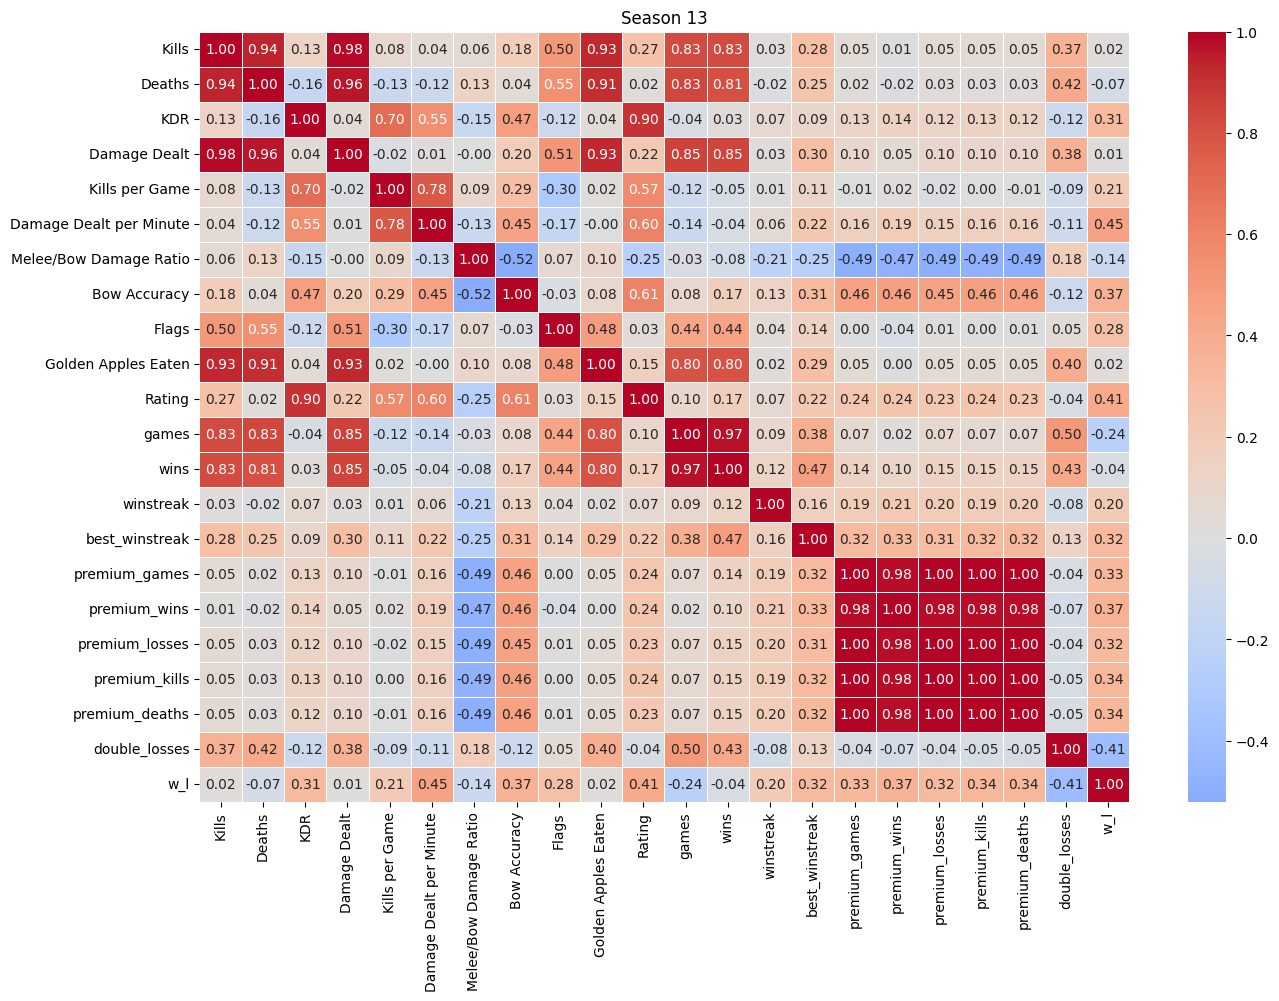

In [20]:
corr = s13.drop(['season', 'Wins', 'losses', 'Ranking', 'best_elo', 'elo'], axis=1).corr(method='spearman', numeric_only=True)

plt.figure(figsize=(15,10))
plt.title("Season 13")
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5, linecolor='white')

#### Results
The strongest positive correlations were found to be kills per game (0.36), damage dealt per minute (0.35), and rating (0.30). The notable negative correlations except for the double losses (-0.40) were the variables related to premium queue, all negatively correlated at around ~0.20.

#### 4.2.1.2 Season 14

<AxesSubplot: title={'center': 'Season 14'}>

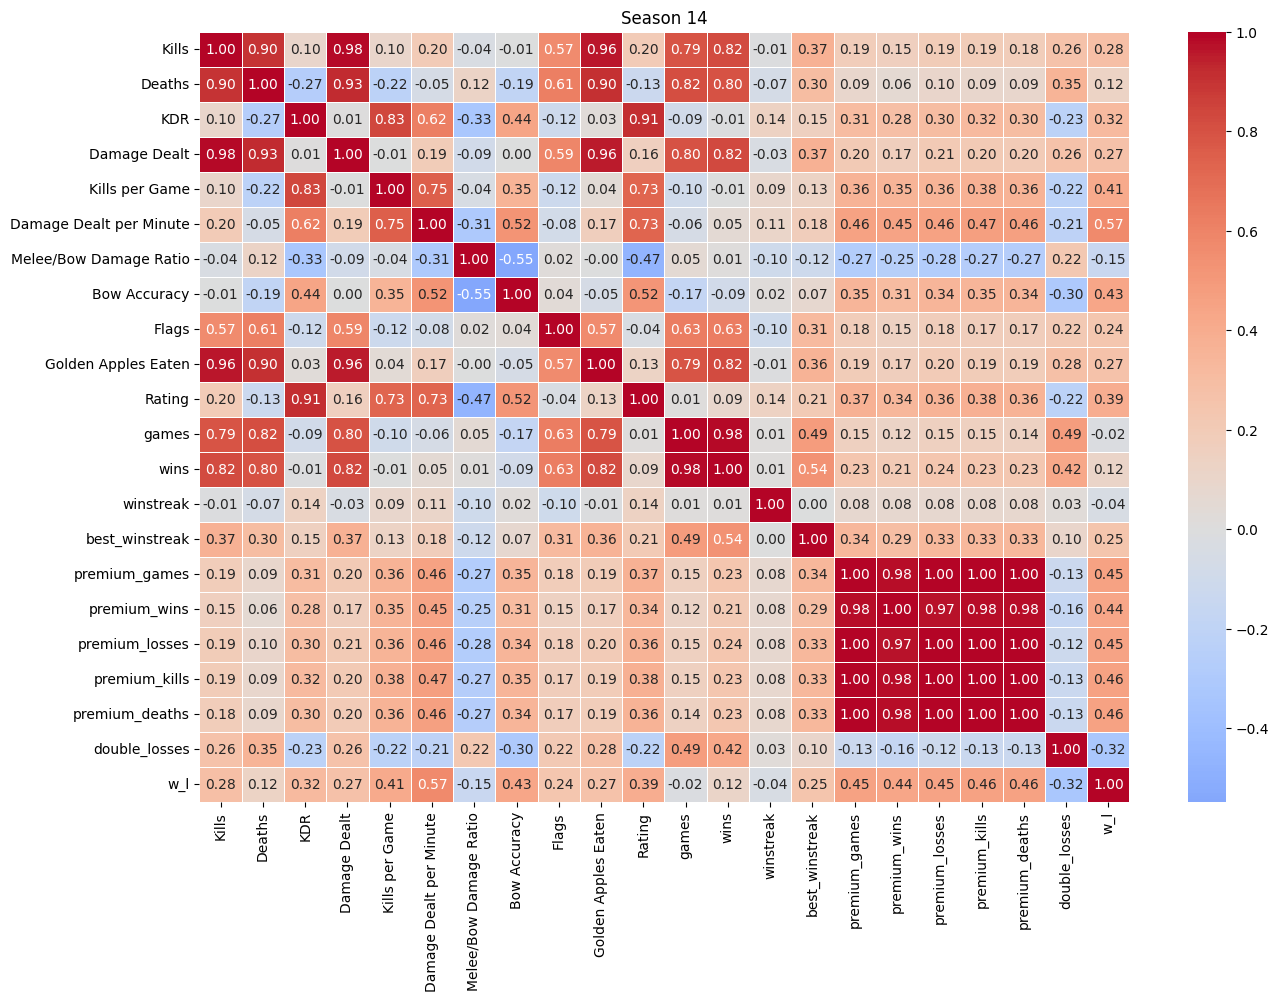

In [21]:
corr = s14.drop(['season', 'Wins', 'losses', 'Ranking', 'best_elo', 'elo'], axis=1).corr(method='spearman', numeric_only=True)

plt.figure(figsize=(15,10))
plt.title("Season 14")
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5, linecolor='white')

#### Results
The strongest positive correlations were found to be damage dealt per minute (0.39), bow accuracy (0.36), and rating (0.27). The only notable negative correlation was double losses (0.37). It's also worth noting that the correlation between premium queue variables and win rate have drastically changed compared to season 13, where they were negatively correlated, now they're mostly close to being neutral.

#### 4.2.1.3 Season 15 (ongoing)

<AxesSubplot: title={'center': 'Season 15'}>

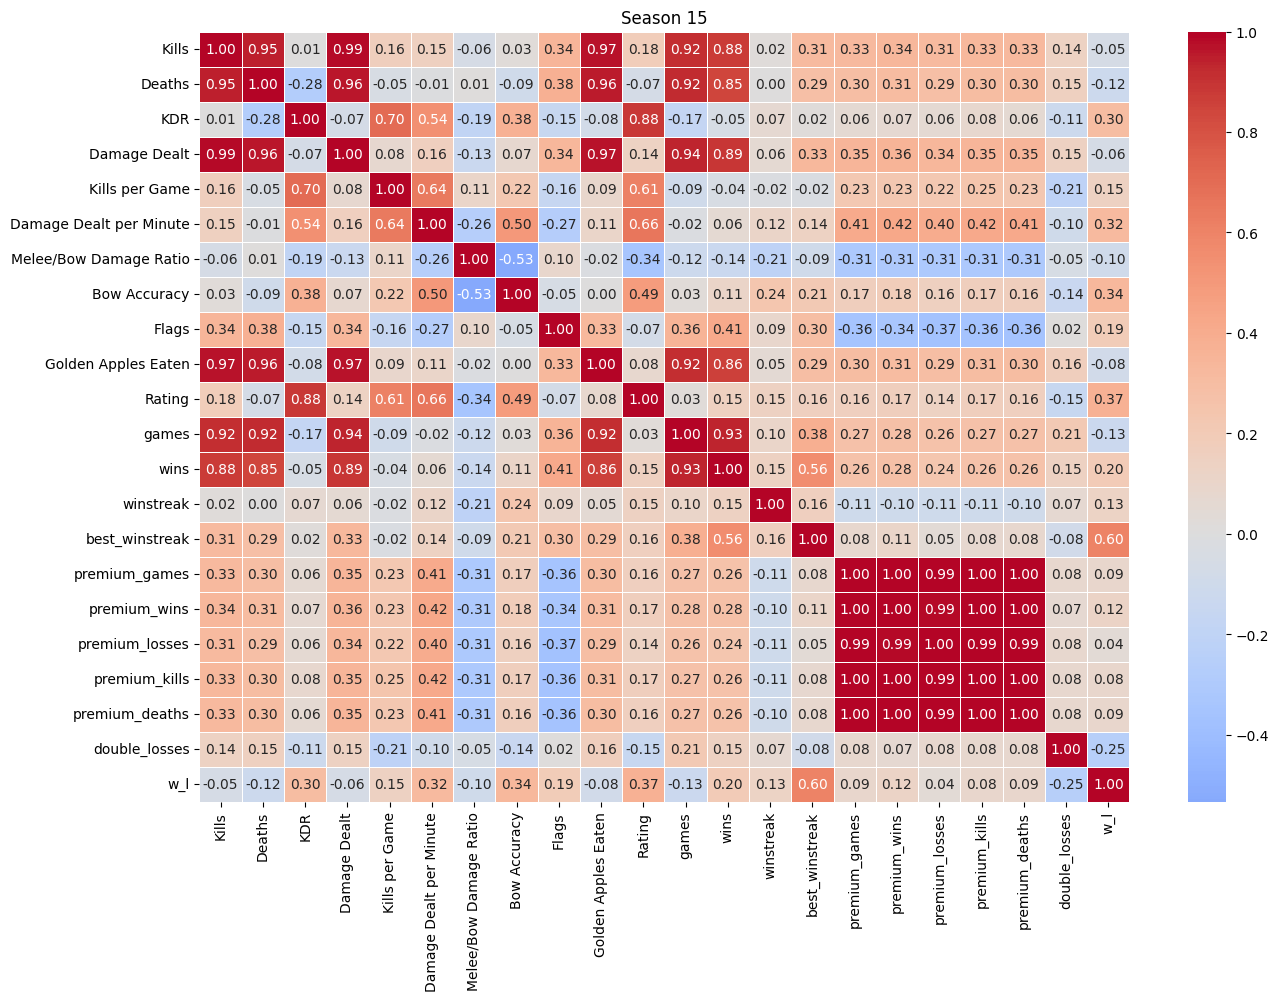

In [22]:
corr = s15.drop(['season', 'Wins', 'losses', 'Ranking', 'best_elo', 'elo'], axis=1).corr(method='spearman', numeric_only=True)

plt.figure(figsize=(15,10))
plt.title("Season 15")
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5, linecolor='white')

#### Results
The strongest positive correlations were found to be best winstreak (0.30), winstreak (0.17), and flags (0.17). On the other hand, variables related to premium queue demonstrated a negative trend, with correlations ranging around -0.35, which is even a more significant negative correlation than what was observed in season 13.
<br>
<br>
It's worth noting the strong positive correlation between W/L and best winstreak & winstreak, which can likely be attributed to the fact that the season has just recently begun. Players may be inclined to "camp" their stats on the server, particularly in comparison to others, and due to the lower average elo at the start of the season, it does not take as long for players to reach similar elo levels, resulting in increased camping behavior.

#### 4.2.1.4 Summary
In summary, the strongest positive correlations with win-loss ratio were found to be kills per game, damage dealt per minute, rating, bow accuracy, best winstreak, winstreak, and flags. The notable negative correlations were double losses and variables related to premium queue, which were negatively correlated in season 13 and mostly neutral in season 14, but again negatively correlated in season 15. The correlation between W/L and best winstreak & winstreak may be attributed to the start of the season and increased "camping" behavior.

### 4.2.2 Scatter Matrices
---

I will now use scatter matrices to gain a deeper understanding of the data in the columns that are most positively correlated with W/L. For each scatter matrix, I will include a colorbar on the right-hand side to indicate the ELO range of each player. Additionally, I will label the 3 most extreme outliers on the left and the 3 most extreme outliers on the right with their player names.

#### Create custom colorbar

In [23]:
# Create custom cbar for rank colors (bronze/silver/gold/emerald/diamond/plasma)
import matplotlib.colors as mcolors

# Define colors
colors = [(111/255, 50/255, 42/255), (107/255, 110/255, 121/255), (255/255, 173/255, 0/255), (24/255, 200/255, 82/255), (0/255, 237/255, 252/255), (44/255, 20/255, 69/255)]

# Define value ranges
vals = [0, 200, 400, 600, 800, 1000, 1300]

# Create the colormap
cmap = mcolors.ListedColormap(colors, name='custom')

# Create the norm
norm = mcolors.BoundaryNorm(vals, cmap.N)

#### 4.2.2.1 Kills per Game
---

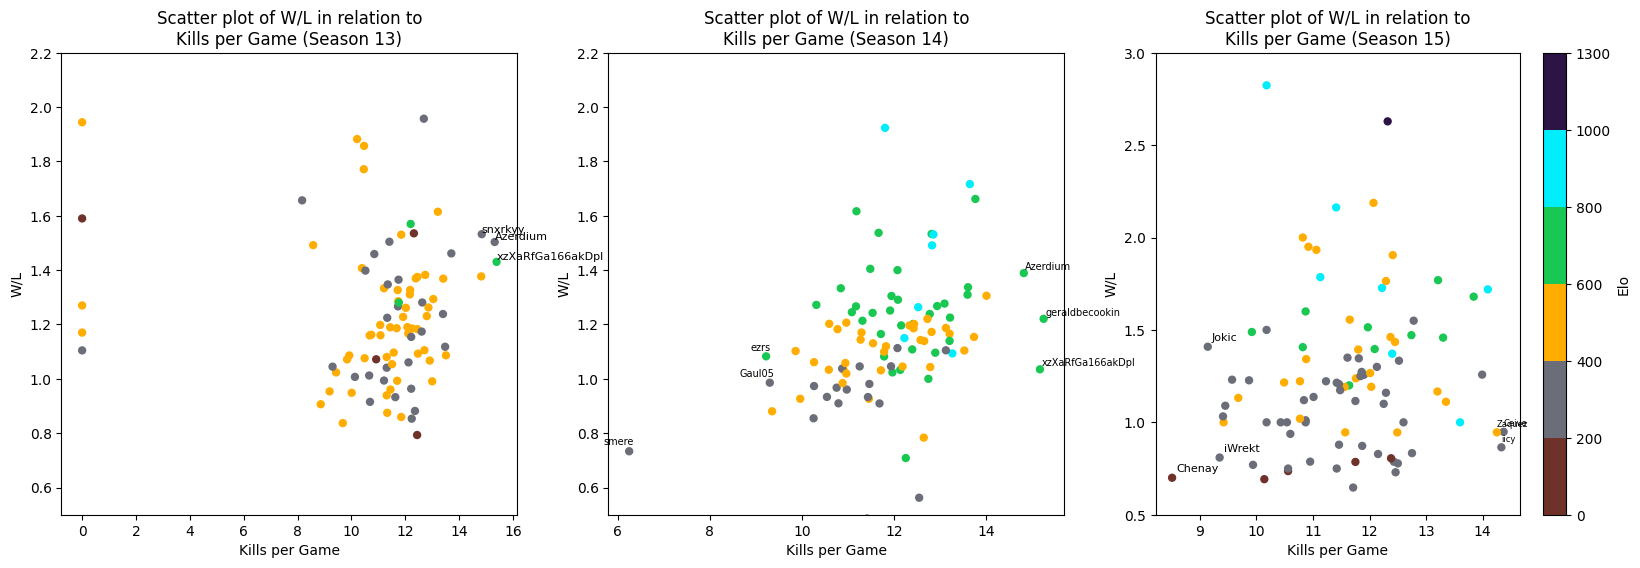

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Find the top 3 outliers (top/low) for Rating in s13 DataFrame
top_outliers = s13.nlargest(3, 'Kills per Game')
#banned players
#low_outliers = s13.nsmallest(3, 'Kills per Game')

# Plot the scatter plot
sc = axs[0].scatter(x=s13['Kills per Game'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Kills per Game')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nKills per Game (Season 13)')
#fig.colorbar(sc, ax=axs[0], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=8)

#for i, player in low_outliers.iterrows():
#    axs[0].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(-15,5), textcoords='offset points', ha='left', va='bottom', fontsize=10)

# Find the top 3 outliers (top/low) for Kills per Game in s14 DataFrame
top_outliers = s14.nlargest(3, 'Kills per Game')
low_outliers = s14.nsmallest(3, 'Kills per Game')

# Plot the scatter plot
sc = axs[1].scatter(x=s14['Kills per Game'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Kills per Game')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nKills per Game (Season 14)')
#fig.colorbar(sc, ax=axs[1], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(3,3), textcoords='offset points', ha='right', va='bottom', fontsize=7)


# Find the top 3 outliers (top/low) for Kills per Game in s15 DataFrame
top_outliers = s15.nlargest(3, 'Kills per Game')
low_outliers = s15.nsmallest(3, 'Kills per Game')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Kills per Game'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Kills per Game')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nKills per Game (Season 15)')
fig.colorbar(sc, ax=axs[2], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(0,3), textcoords='offset points', ha='left', va='bottom', fontsize=6)

for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(3,3), textcoords='offset points', ha='left', va='bottom', fontsize=8)

plt.show()

#### 4.2.2.2  Damage Dealt per Minute
---

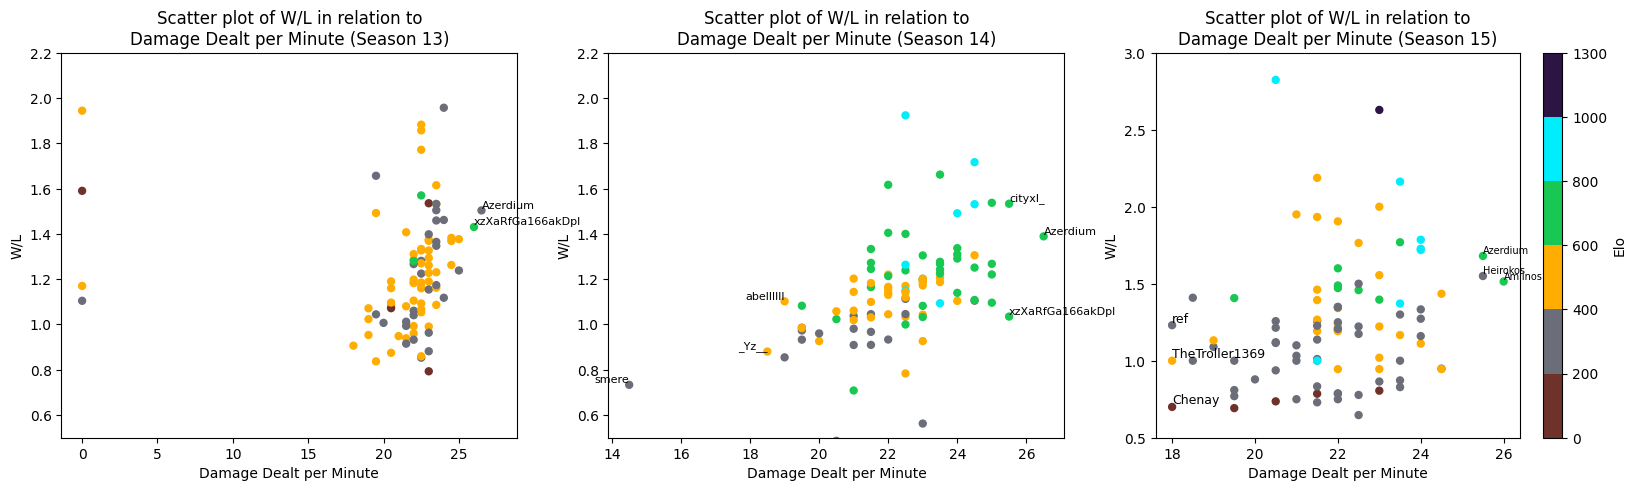

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Find the top 3 outliers (top/low) for Damage Dealt per Minute in s13 DataFrame
top_outliers = s13.nlargest(3, 'Damage Dealt per Minute')
# all banned players
#low_outliers = s13.nsmallest(3, 'Damage Dealt per Minute')

#Plot the scatter plot
sc = axs[0].scatter(x=s13['Damage Dealt per Minute'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Damage Dealt per Minute')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nDamage Dealt per Minute (Season 13)')
#fig.colorbar(sc, ax=axs[0], label="Elo")

#Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=8)

#for i, player in low_outliers.iterrows():
#    axs[0].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(-15,5), textcoords='offset points', ha='left', va='bottom', fontsize=10)

# Find the top 3 outliers (top/low) for Damage Dealt per Minute in s14 DataFrame
top_outliers = s14.nlargest(3, 'Damage Dealt per Minute')
low_outliers = s14.nsmallest(3, 'Damage Dealt per Minute')

#Plot the scatter plot
sc = axs[1].scatter(x=s14['Damage Dealt per Minute'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Damage Dealt per Minute')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nDamage Dealt per Minute (Season 14)')
#fig.colorbar(sc, ax=axs[1], label="Elo")

#Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=8)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='right', va='bottom', fontsize=8)

#Find the top 3 outliers (top/low) for Damage Dealt per Minute in s15 DataFrame
top_outliers = s15.nlargest(3, 'Damage Dealt per Minute')
low_outliers = s15.nsmallest(3, 'Damage Dealt per Minute')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Damage Dealt per Minute'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Damage Dealt per Minute')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nDamage Dealt per Minute (Season 15)')
fig.colorbar(sc, ax=axs[2], label="Elo")

#Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)
for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=9)
    
plt.show()

#### 4.2.2.3 Rating
---

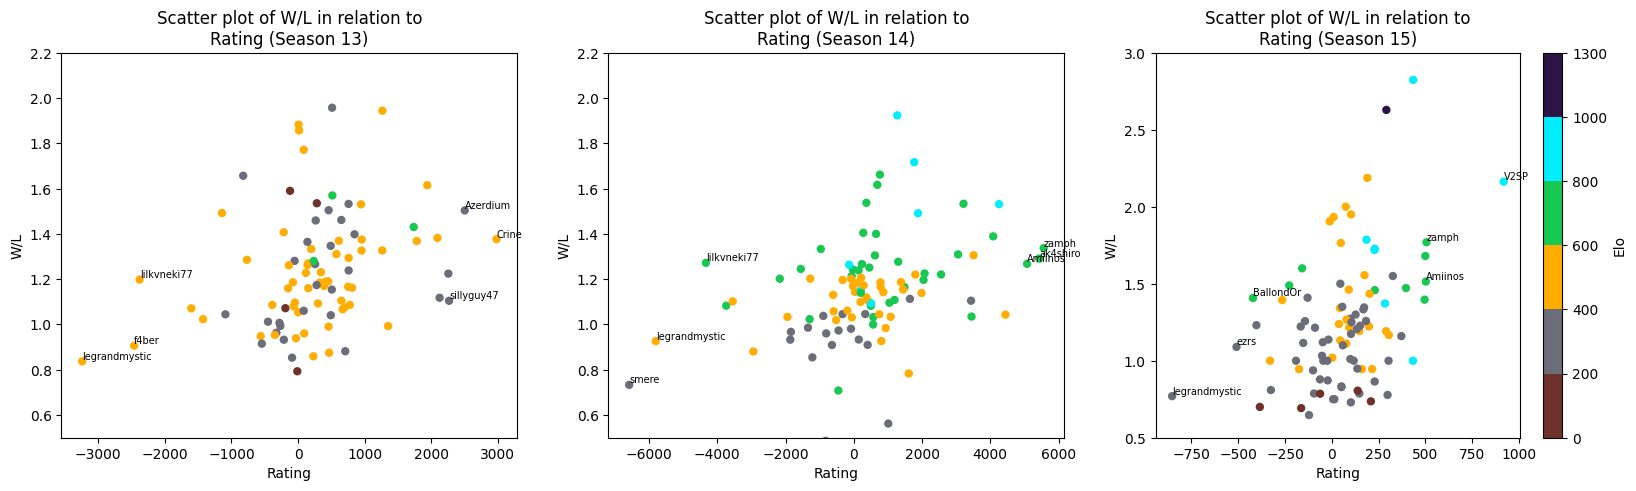

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Find the top 3 outliers (top/low) for Rating in s13 DataFrame
top_outliers = s13.nlargest(3, 'Rating')
low_outliers = s13.nsmallest(3, 'Rating')

# Plot the scatter plot
sc = axs[0].scatter(x=s13['Rating'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nRating (Season 13)')
#fig.colorbar(sc, ax=axs[0], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

# Find the top 3 outliers (top/low) for Rating in s14 DataFrame
top_outliers = s14.nlargest(3, 'Rating')
low_outliers = s14.nsmallest(3, 'Rating')

# Plot the scatter plot
sc = axs[1].scatter(x=s14['Rating'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nRating (Season 14)')
#fig.colorbar(sc, ax=axs[1], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)


# Find the top 3 outliers (top/low) for Rating in s15 DataFrame
top_outliers = s15.nlargest(3, 'Rating')
low_outliers = s15.nsmallest(3, 'Rating')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Rating'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Rating')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nRating (Season 15)')
fig.colorbar(sc, ax=axs[2], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

plt.show()

#### 4.2.2.4 Bow Accuracy
---

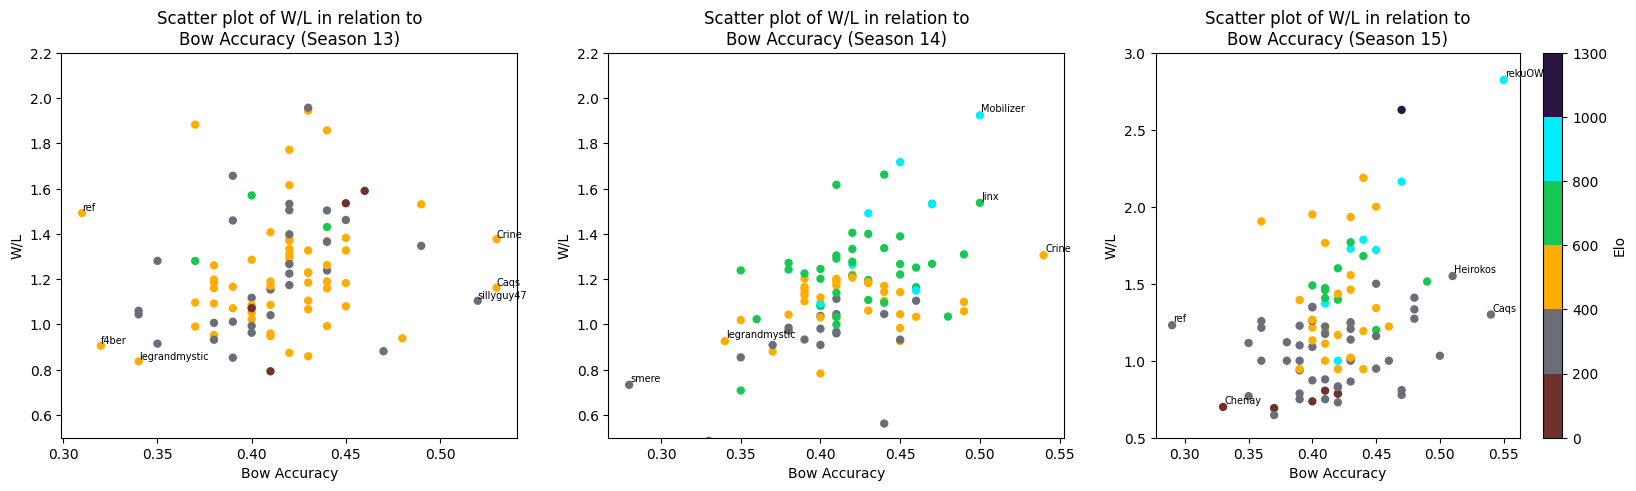

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Find the top 3 outliers (top/low) for Bow Accuracy in s13 DataFrame
top_outliers = s13.nlargest(3, 'Bow Accuracy')
low_outliers = s13.nsmallest(3, 'Bow Accuracy')

# Plot the scatter plot
sc = axs[0].scatter(x=s13['Bow Accuracy'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Bow Accuracy')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nBow Accuracy (Season 13)')
#fig.colorbar(sc, ax=axs[0], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

# Find the top 3 outliers (top/low) for Bow Accuracy in s14 DataFrame
top_outliers = s14.nlargest(3, 'Bow Accuracy')
low_outliers = s14.nsmallest(3, 'Bow Accuracy')

# Plot the scatter plot
sc = axs[1].scatter(x=s14['Bow Accuracy'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Bow Accuracy')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nBow Accuracy (Season 14)')
#fig.colorbar(sc, ax=axs[1], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

# Find the top 3 outliers (top/low) for Bow Accuracy
top_outliers = s15.nlargest(3, 'Bow Accuracy')
low_outliers = s15.nsmallest(3, 'Bow Accuracy')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Bow Accuracy'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Bow Accuracy')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nBow Accuracy (Season 15)')
fig.colorbar(sc, ax=axs[2], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

plt.show()

#### 4.2.2.5 Summary
---
*TBA

## 4.3 Premium Queue Players
---
In this section I will strictly look at statistics from premium queue, specifically at W/L and understand which players win the most in premium queue along with which players lose the most in premium queue. I've set the threshold to $>50$ games, meaning I will only include players who have played more than 40 premium queue games / season to avoid including inactive players and non-prem players.

In [28]:
def create_prem_df(df, threshold=40):
    df = df[['Player', 'premium_games', 'premium_wins', 'premium_losses']]
    df = df[df.premium_games != 0]
    df = df[df.premium_games > threshold]
    df["w_l"] = df["premium_wins"] / df["premium_losses"]
    return df
#premium_df.sort_values('w_l', ascending=False)

## 4.3.1 Season 13
---

In [29]:
s13_prem = create_prem_df(s13)
dsc_s13 = s13_prem.sort_values('w_l', ascending=False)
asc_s13 = s13_prem.sort_values('w_l', ascending=True)

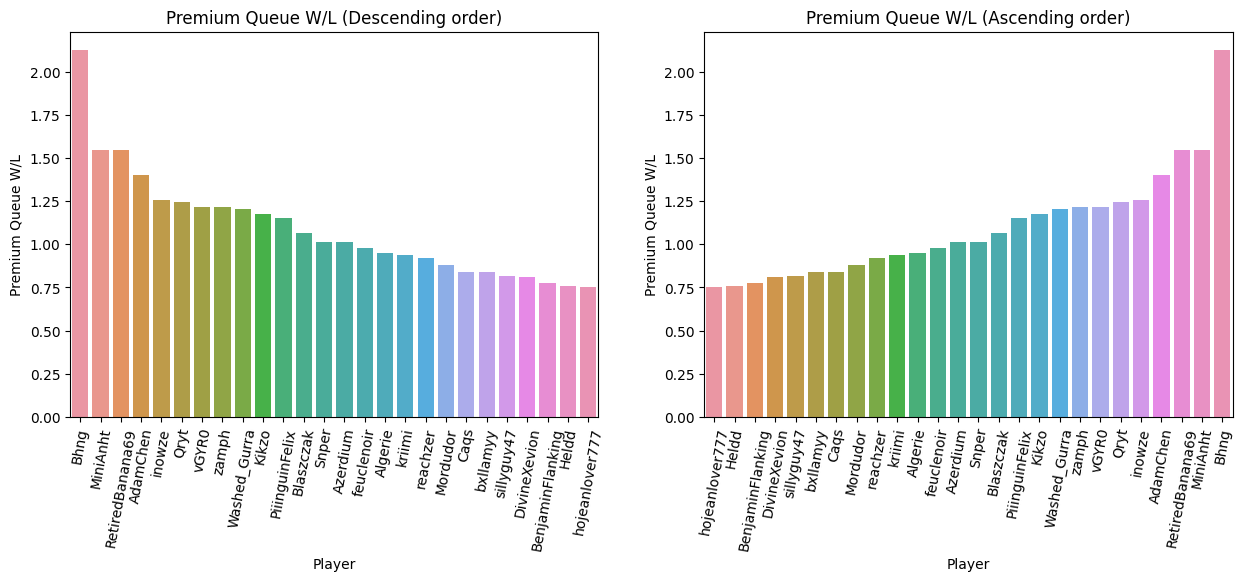

In [30]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the data in the first subplot
sns.barplot(x="Player", y="w_l", data=dsc_s13, ax=axs[0])

# add x and y labels
axs[0].set_xlabel('Player')
axs[0].set_ylabel('Premium Queue W/L')

# add a title
axs[0].set_title('Premium Queue W/L (Descending order)')

# rotate x-axis labels by 45 degrees
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=80)

# Plot the data in the second subplot
sns.barplot(x="Player", y="w_l", data=asc_s13, ax=axs[1])

# add x and y labels
axs[1].set_xlabel('Player')
axs[1].set_ylabel('Premium Queue W/L')

# add a title
axs[1].set_title('Premium Queue W/L (Ascending order)')

# rotate x-axis labels by 45 degrees
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=80)

# show plot
plt.show()

## 4.3.2 Season 14
---

In [31]:
s14_prem = create_prem_df(s14)
dsc_s14 = s14_prem.sort_values('w_l', ascending=False)
asc_s14 = s14_prem.sort_values('w_l', ascending=True)

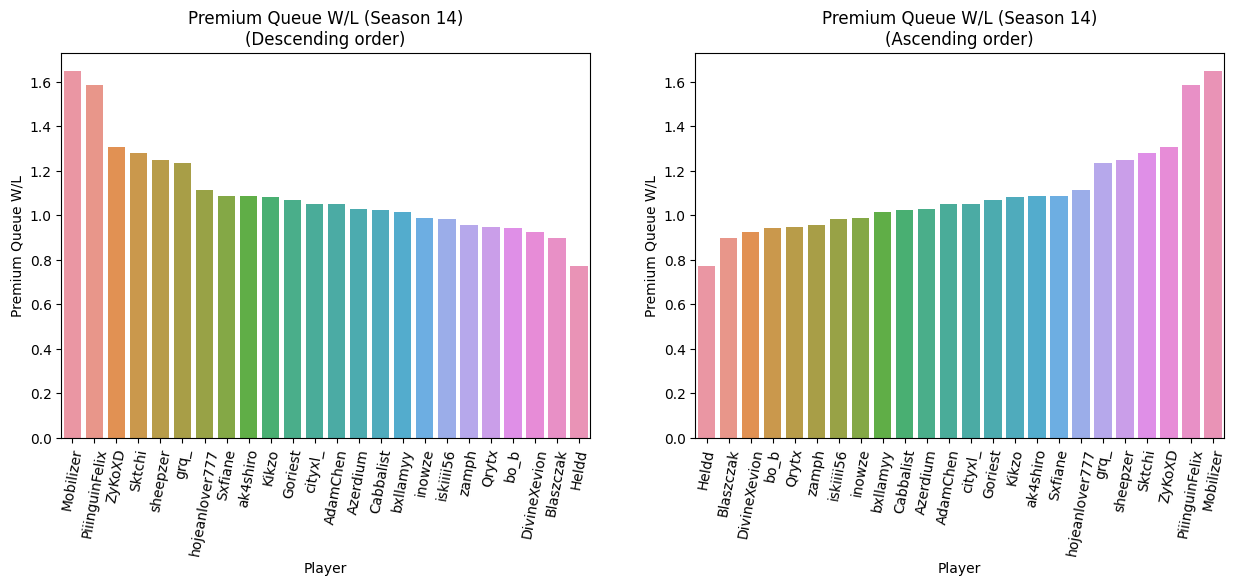

In [32]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the data in the first subplot
sns.barplot(x="Player", y="w_l", data=dsc_s14, ax=axs[0])

# add x and y labels
axs[0].set_xlabel('Player')
axs[0].set_ylabel('Premium Queue W/L')

# add a title
axs[0].set_title('Premium Queue W/L (Season 14)\n(Descending order)')

# rotate x-axis labels by 45 degrees
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=80)

# Plot the data in the second subplot
sns.barplot(x="Player", y="w_l", data=asc_s14, ax=axs[1])

# add x and y labels
axs[1].set_xlabel('Player')
axs[1].set_ylabel('Premium Queue W/L')

# add a title
axs[1].set_title('Premium Queue W/L (Season 14)\n(Ascending order)')

# rotate x-axis labels by 45 degrees
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=80)

# show plot
plt.show()

## 4.3.3 Season 15
---

In [33]:
s15_prem = create_prem_df(s15)
dsc_s15 = s15_prem.sort_values('w_l', ascending=False)
asc_s15 = s15_prem.sort_values('w_l', ascending=True)

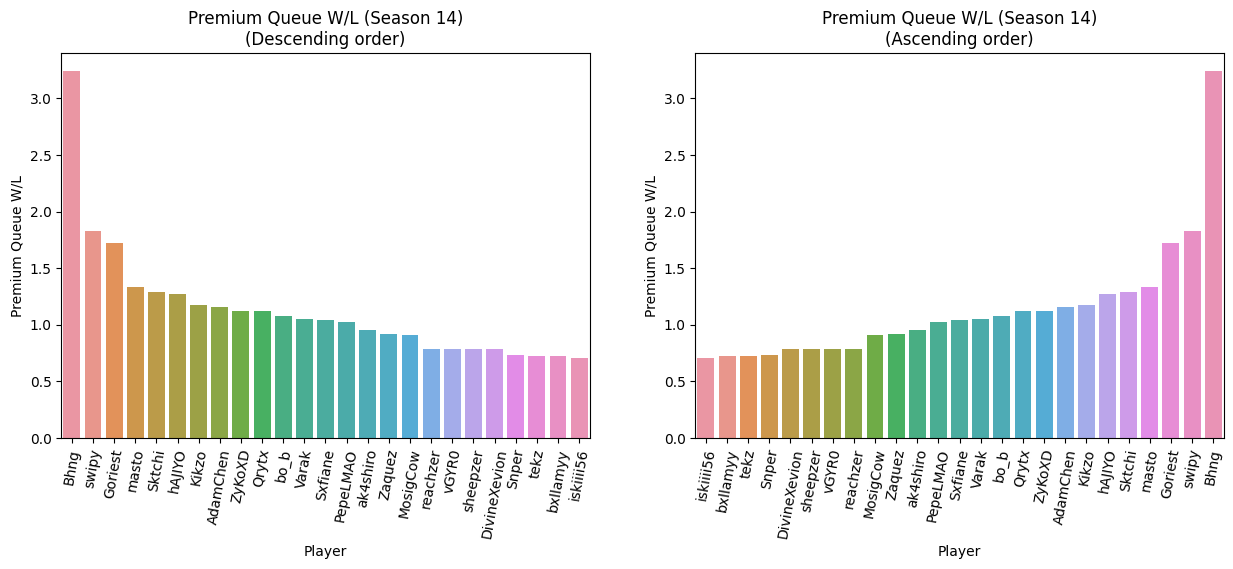

In [34]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the data in the first subplot
sns.barplot(x="Player", y="w_l", data=dsc_s15, ax=axs[0])

# add x and y labels
axs[0].set_xlabel('Player')
axs[0].set_ylabel('Premium Queue W/L')

# add a title
axs[0].set_title('Premium Queue W/L (Season 14)\n(Descending order)')

# rotate x-axis labels by 45 degrees
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=80)

# Plot the data in the second subplot
sns.barplot(x="Player", y="w_l", data=asc_s15, ax=axs[1])

# add x and y labels
axs[1].set_xlabel('Player')
axs[1].set_ylabel('Premium Queue W/L')

# add a title
axs[1].set_title('Premium Queue W/L (Season 14)\n(Ascending order)')

# rotate x-axis labels by 45 degrees
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=80)

# show plot
plt.show()

## 4.4 Gol
---

In [35]:
s13.columns

Index(['Ranking', 'Player', 'Wins', 'Kills', 'Deaths', 'KDR', 'Damage Dealt',
       'Kills per Game', 'Damage Dealt per Minute', 'Melee/Bow Damage Ratio',
       'Bow Accuracy', 'Flags', 'Golden Apples Eaten', 'Rating', 'best_elo',
       'games', 'wins', 'winstreak', 'best_winstreak', 'losses',
       'premium_games', 'premium_wins', 'premium_losses', 'premium_kills',
       'premium_deaths', 'double_losses', 'elo', 'season', 'w_l'],
      dtype='object')

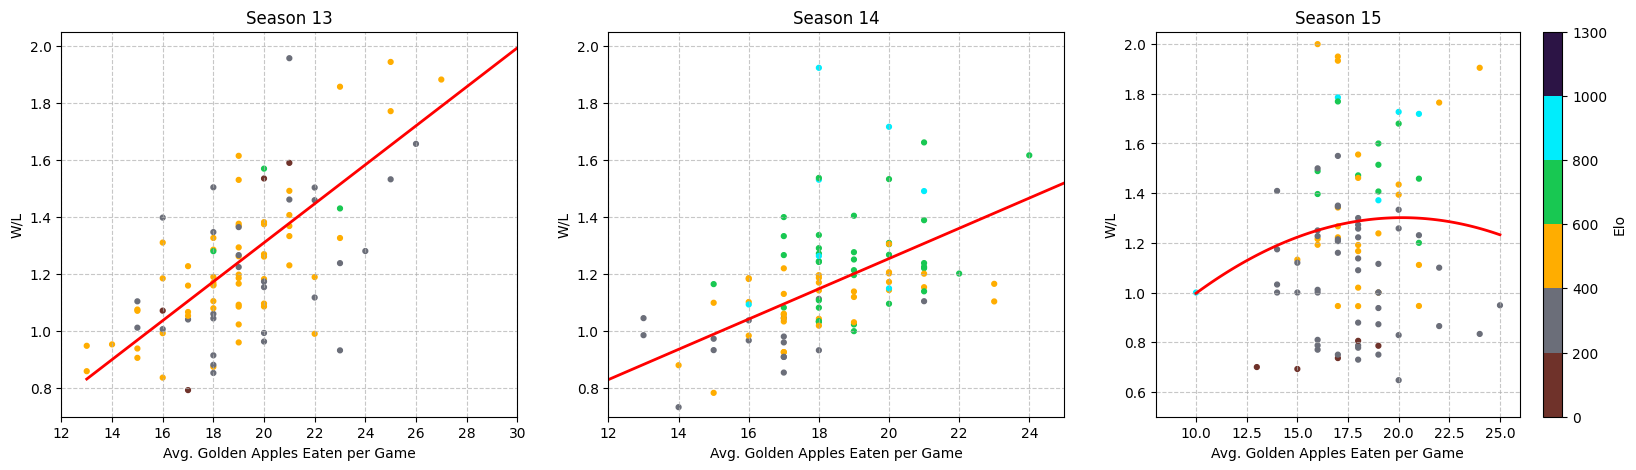

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Replace inf and -inf values with NaN
s13 = s13.replace([np.inf, -np.inf], np.nan)
s13 = s13.dropna()
s14 = s14.replace([np.inf, -np.inf], np.nan)
s14 = s14.dropna()
s15 = s15.replace([np.inf, -np.inf], np.nan)
s15 = s15.dropna()

# Create a new column for average golden apples eaten per game
s13['avg_golden_apples_per_game'] = round(s13['Golden Apples Eaten'] / s13['games'].astype(int))
s14['avg_golden_apples_per_game'] = round(s14['Golden Apples Eaten'] / s14['games'].astype(int))
s15['avg_golden_apples_per_game'] = round(s15['Golden Apples Eaten'] / s15['games'].astype(int))

# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Scatter plot for s13 dataset
axs[0].scatter(s13['avg_golden_apples_per_game'], s13['w_l'], c=s13['elo'], cmap=cmap, norm=norm, s=12)
axs[0].set_title('Season 13')
axs[0].set_xlabel('Avg. Golden Apples Eaten per Game')
axs[0].set_ylabel('W/L')
axs[0].set_xlim(12, 30)
axs[0].set_ylim(0.7, 2.05)

# Get the x and y values for the trendline
xdata = s13['avg_golden_apples_per_game']
ydata = s13['w_l']

# Fit a polynomial function to the data
coef = np.polyfit(xdata, ydata, 2)

# Get the trendline function
trendline = np.poly1d(coef)

# Plot the trendline
x_vals = np.linspace(min(xdata), max(xdata), 100)
axs[0].plot(x_vals, trendline(x_vals), 'r-', linewidth=2)

# Add gridlines
axs[0].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for s14 dataset
axs[1].scatter(s14['avg_golden_apples_per_game'], s14['w_l'], c=s14['elo'], cmap=cmap, norm=norm, s=12)
axs[1].set_title('Season 14')
axs[1].set_xlabel('Avg. Golden Apples Eaten per Game')
axs[1].set_ylabel('W/L')
axs[1].set_xlim(12, 25)
axs[1].set_ylim(0.7, 2.05)

# Get the x and y values for the trendline
xdata = s14['avg_golden_apples_per_game']
ydata = s14['w_l']

# Fit a polynomial function to the data
coef = np.polyfit(xdata, ydata, 2)

# Get the trendline function
trendline = np.poly1d(coef)

# Plot the trendline
x_vals = np.linspace(min(xdata), max(xdata), 100)
axs[1].plot(x_vals, trendline(x_vals), 'r-', linewidth=2)

# Add gridlines
axs[1].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for s15 dataset
axs[2].scatter(s15['avg_golden_apples_per_game'], s15['w_l'], c=s15['elo'], cmap=cmap, norm=norm, s=12)
axs[2].set_title('Season 15')
axs[2].set_xlabel('Avg. Golden Apples Eaten per Game')
axs[2].set_ylabel('W/L')
axs[2].set_xlim(8, 26)
axs[2].set_ylim(0.5, 2.05)

# Get the x and y values for the trendline
xdata = s15['avg_golden_apples_per_game']
ydata = s15['w_l']

# Fit a polynomial function to the data
coef = np.polyfit(xdata, ydata, 2)

# Get the trendline function
trendline = np.poly1d(coef)

# Plot the trendline
x_vals = np.linspace(min(xdata), max(xdata), 100)
axs[2].plot(x_vals, trendline(x_vals), 'r-', linewidth=2)

# Add gridlines
axs[2].grid(True, linestyle='--', alpha=0.7)

# Show plot
fig.colorbar(sc, ax=axs[2], label="Elo")
plt.show()

# 3 To be added
- Scrape data from "Stats" tab on player profiles, to get all time data that isn't included in the scraping done for the leaderboard page (such as games and losses).